# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups          
Sample_087  E5RJR5;P63208              17.499
Sample_012  P01700                     19.530
Sample_130  P13611;P13611-5            17.883
Sample_048  P19021;P19021-5;P19021-6   19.990
Sample_024  Q9NQ30                     12.703
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups 
Sample_044  P01817            10.551
Sample_156  Q99650;Q99650-2   11.370
Sample_132  O00187;O00187-2   14.188
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.546
            A0A075B6Q5                 11.523
            A0A075B6R2                 12.722
            A0A075B6S5                 12.762
            A0A087WSY4                 13.050
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.568
            Q9UI40;Q9UI40-2            12.235
            Q9UIW2                     12.994
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.483
            Q9UP79                     12.509
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,10.766,15.050,16.842,19.863,13.666,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,14.643,19.067,...,15.528,15.576,13.097,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,13.932,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,13.894,17.705,17.039,13.972,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.043,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.719,15.345,17.084,18.708,14.249,19.433,8.327,7.984
Sample_207,15.739,16.877,15.469,16.898,12.843,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,11.794,14.132,12.089,12.362,11.973,12.764,13.373,12.536,13.493,11.882
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.908,19.067,16.127,...,13.197,13.016,12.502,12.277,13.170,13.062,13.615,13.598,14.330,13.670
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.607,11.878,12.265,13.117,13.582,12.314,12.891,13.345,13.845,12.613
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.687,12.802,13.663,12.678,13.504,14.196,14.088,13.511,12.192,12.763
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.920,13.321,12.068,12.995,14.217,12.394,12.794,12.400,13.111,13.308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.183,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 317.46it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]

100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  9.03it/s]

100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

100%|██████████| 3/3 [00:00<00:00,  6.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.32it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

100%|██████████| 4/4 [00:00<00:00,  3.87it/s]

100%|██████████| 4/4 [00:00<00:00,  4.16it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.90it/s]

 60%|██████    | 3/5 [00:00<00:00,  6.47it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.66it/s]

100%|██████████| 5/5 [00:00<00:00,  5.21it/s]

100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.18it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.11it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.20it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.78it/s]

100%|██████████| 6/6 [00:01<00:00,  2.65it/s]

100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.39it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.09it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.72it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.83it/s]

100%|██████████| 7/7 [00:02<00:00,  2.82it/s]

100%|██████████| 7/7 [00:02<00:00,  2.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.89it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.76it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.78it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.38it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.32it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.49it/s]

100%|██████████| 8/8 [00:02<00:00,  3.72it/s]

100%|██████████| 8/8 [00:02<00:00,  3.71it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.72it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.67it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.38it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.54it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.52it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.50it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.40it/s]

100%|██████████| 9/9 [00:01<00:00,  4.48it/s]

100%|██████████| 9/9 [00:01<00:00,  4.55it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.25it/s]

 30%|███       | 3/10 [00:00<00:01,  6.44it/s]

 40%|████      | 4/10 [00:00<00:01,  5.50it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.96it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.71it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.25it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.26it/s]

100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

100%|██████████| 10/10 [00:02<00:00,  4.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 12.79it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.84it/s]

 45%|████▌     | 5/11 [00:00<00:00,  6.40it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.95it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.19it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.74it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.66it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.63it/s]

100%|██████████| 11/11 [00:02<00:00,  3.83it/s]

100%|██████████| 11/11 [00:02<00:00,  4.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.28it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.70it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.62it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.46it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.44it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.07it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.39it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.24it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.03it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.93it/s]

100%|██████████| 12/12 [00:03<00:00,  2.69it/s]

100%|██████████| 12/12 [00:03<00:00,  3.46it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.66it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.40it/s]

 31%|███       | 4/13 [00:00<00:01,  5.61it/s]

 38%|███▊      | 5/13 [00:00<00:01,  5.13it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.96it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.83it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.66it/s]

 69%|██████▉   | 9/13 [00:01<00:01,  3.51it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.01it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  2.68it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.58it/s]

100%|██████████| 13/13 [00:03<00:00,  2.50it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.54it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.62it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.14it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.89it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.65it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.54it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.89it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.49it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.07it/s]

 79%|███████▊  | 11/14 [00:02<00:01,  2.69it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.54it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.44it/s]

100%|██████████| 14/14 [00:04<00:00,  2.45it/s]

100%|██████████| 14/14 [00:04<00:00,  3.26it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.75it/s]

 20%|██        | 3/15 [00:00<00:01,  6.25it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.26it/s]

 33%|███▎      | 5/15 [00:00<00:02,  5.00it/s]

 40%|████      | 6/15 [00:01<00:01,  4.82it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.70it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.59it/s]

 60%|██████    | 9/15 [00:01<00:01,  3.97it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.55it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.23it/s]

 80%|████████  | 12/15 [00:03<00:01,  3.00it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.85it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  2.71it/s]

100%|██████████| 15/15 [00:04<00:00,  2.73it/s]

100%|██████████| 15/15 [00:04<00:00,  3.58it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.010          0.695 0.393       0.101   
2             0.005 0.006      0.050 0.020          0.699 0.102       0.625   
3             0.005 0.004      0.054 0.030          0.743 0.117       0.650   
4             0.004 0.002      0.045 0.019          0.733 0.106       0.680   
5             0.005 0.004      0.059 0.031          0.726 0.105       0.673   
6             0.004 0.002      0.041 0.017          0.724 0.101       0.693   
7             0.003 0.000      0.034 0.000          0.735 0.103       0.685   
8             0.005 0.005      0.047 0.026          0.789 0.082       0.822   
9             0.005 0.004      0.061 0.028          0.783 0.085       0.799   
10            0.006 0.006      0.067 0.031          0.810 0.080       0.842   
11            0.008 0.008      0.069 0.028          0.808 0.081       0.840   
12            0.005 0.004      0.052 0.024          0.805 0.083       0.832   
13            0.005 0.004      0.049 0.017          0.807 0.088       0.835   
14            0.005 0.003      0.052 0.020          0.800 0.087       0.836   
15            0.005 0.004      0.055 0.023          0.802 0.088       0.816   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.170 0.126                  0.543 0.039        0.845   
2          0.110   0.653 0.083                  0.711 0.063        0.787   
3          0.122   0.684 0.087                  0.737 0.066        0.795   
4          0.122   0.697 0.086                  0.746 0.067        0.802   
5          0.122   0.691 0.088                  0.741 0.068        0.800   
6          0.109   0.702 0.079                  0.747 0.064        0.801   
7          0.117   0.702 0.088                  0.750 0.066        0.807   
8          0.103   0.800 0.070                  0.829 0.062        0.888   
9          0.121   0.786 0.080                  0.817 0.068        0.889   
10         0.088   0.823 0.066                  0.847 0.058        0.907   
11         0.089   0.820 0.067                  0.846 0.059        0.907   
12         0.088   0.815 0.067                  0.841 0.059        0.905   
13         0.085   0.817 0.067                  0.842 0.059        0.901   
14         0.092   0.814 0.072                  0.840 0.064        0.901   
15         0.094   0.805 0.069                  0.833 0.059        0.907   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.820 0.089        210.000 0.000  
2          0.072                  0.754 0.089        210.000 0.000  
3          0.074                  0.738 0.101        210.000 0.000  
4          0.066                  0.743 0.085        210.000 0.000  
5          0.067                  0.740 0.086        210.000 0.000  
6          0.066                  0.749 0.087        210.000 0.000  
7          0.066                  0.757 0.084        210.000 0.000  
8          0.053                  0.857 0.067        210.000 0.000  
9          0.053                  0.863 0.063        210.000 0.000  
10         0.052                  0.901 0.051        210.000 0.000  
11         0.052                  0.900 0.050        210.000 0.000  
12         0.052                  0.898 0.051        210.000 0.000  
13         0.052                  0.893 0.051        210.000 0.000  
14         0.053                  0.895 0.050        210.000 0.000  
15         0.051                  0.906 0.046 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 450.27it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.11it/s]

100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.07it/s]

100%|██████████| 3/3 [00:00<00:00,  3.67it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.84it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.83it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.52it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.75it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.14it/s]

100%|██████████| 5/5 [00:01<00:00,  3.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.89it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.77it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.59it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.33it/s]

100%|██████████| 6/6 [00:01<00:00,  4.14it/s]

100%|██████████| 6/6 [00:01<00:00,  4.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.09it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.01it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.47it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.66it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.54it/s]

100%|██████████| 7/7 [00:01<00:00,  3.62it/s]

100%|██████████| 7/7 [00:01<00:00,  3.98it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.72it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.70it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.34it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.14it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.05it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.06it/s]

100%|██████████| 8/8 [00:02<00:00,  3.40it/s]

100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  9.47it/s]

 33%|███▎      | 3/9 [00:00<00:00,  6.78it/s]

 44%|████▍     | 4/9 [00:00<00:00,  5.48it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.10it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.83it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.77it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.82it/s]

100%|██████████| 9/9 [00:02<00:00,  3.60it/s]

100%|██████████| 9/9 [00:02<00:00,  4.18it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.52it/s]

 30%|███       | 3/10 [00:00<00:02,  3.42it/s]

 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.68it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.59it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.34it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.25it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.37it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.35it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.53it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.96it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.94it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.76it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.39it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.27it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.45it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.27it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

100%|██████████| 11/11 [00:03<00:00,  3.50it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.15it/s]

 25%|██▌       | 3/12 [00:00<00:03,  2.96it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.73it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.68it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.83it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.66it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.96it/s]

 75%|███████▌  | 9/12 [00:03<00:00,  3.12it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  3.12it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.35it/s]

100%|██████████| 12/12 [00:03<00:00,  3.49it/s]

100%|██████████| 12/12 [00:03<00:00,  3.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.33it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.19it/s]

 31%|███       | 4/13 [00:00<00:02,  4.02it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.78it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.78it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.84it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.33it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.77it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.52it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.39it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.57it/s]

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]

100%|██████████| 13/13 [00:04<00:00,  3.07it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.49it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.28it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.96it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.04it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.19it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.37it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.72it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.55it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.51it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.56it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.59it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.35it/s]

100%|██████████| 14/14 [00:05<00:00,  2.30it/s]

100%|██████████| 14/14 [00:05<00:00,  2.67it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.41it/s]

 20%|██        | 3/15 [00:00<00:04,  2.94it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.85it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.93it/s]

 40%|████      | 6/15 [00:02<00:03,  2.79it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.48it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.28it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.23it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.02it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.04it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.99it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.99it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.10it/s]

100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

100%|██████████| 15/15 [00:06<00:00,  2.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.052 0.019          0.833 0.269       0.151   
2             0.005 0.005      0.049 0.022          0.615 0.119       0.479   
3             0.007 0.006      0.063 0.022          0.822 0.083       0.726   
4             0.004 0.004      0.046 0.017          0.807 0.083       0.769   
5             0.004 0.004      0.051 0.022          0.801 0.082       0.765   
6             0.004 0.002      0.039 0.013          0.791 0.084       0.758   
7             0.003 0.002      0.032 0.007          0.819 0.087       0.786   
8             0.003 0.000      0.034 0.006          0.817 0.087       0.787   
9             0.003 0.000      0.035 0.008          0.813 0.081       0.845   
10            0.004 0.002      0.037 0.008          0.803 0.083       0.830   
11            0.005 0.004      0.047 0.016          0.823 0.070       0.835   
12            0.005 0.004      0.053 0.019          0.806 0.068       0.831   
13            0.004 0.002      0.037 0.008          0.817 0.071       0.842   
14            0.008 0.008      0.070 0.030          0.827 0.067       0.840   
15            0.004 0.003      0.038 0.010          0.825 0.064       0.837   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.087   0.247 0.126                  0.567 0.043        0.850   
2          0.121   0.528 0.099                  0.626 0.066        0.709   
3          0.105   0.766 0.072                  0.804 0.058        0.898   
4          0.104   0.783 0.072                  0.816 0.060        0.900   
5          0.114   0.777 0.077                  0.812 0.063        0.897   
6          0.117   0.769 0.081                  0.805 0.066        0.893   
7          0.105   0.798 0.075                  0.828 0.063        0.902   
8          0.107   0.797 0.074                  0.827 0.062        0.899   
9          0.101   0.825 0.073                  0.850 0.063        0.911   
10         0.099   0.812 0.069                  0.839 0.061        0.912   
11         0.091   0.826 0.062                  0.851 0.053        0.914   
12         0.095   0.815 0.063                  0.842 0.053        0.911   
13         0.087   0.826 0.057                  0.851 0.049        0.914   
14         0.091   0.830 0.058                  0.855 0.049        0.916   
15         0.092   0.827 0.057                  0.853 0.049        0.916   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.824 0.088        210.000 0.000  
2          0.079                  0.659 0.097        210.000 0.000  
3          0.049                  0.881 0.057        210.000 0.000  
4          0.048                  0.880 0.056        210.000 0.000  
5          0.051                  0.877 0.059        210.000 0.000  
6          0.053                  0.873 0.061        210.000 0.000  
7          0.054                  0.887 0.061        210.000 0.000  
8          0.056                  0.884 0.063        210.000 0.000  
9          0.050                  0.898 0.054        210.000 0.000  
10         0.050                  0.902 0.050        210.000 0.000  
11         0.048                  0.902 0.053        210.000 0.000  
12         0.046                  0.899 0.051        210.000 0.000  
13         0.045                  0.901 0.049        210.000 0.000  
14         0.045                  0.905 0.048        210.000 0.000  
15         0.045                  0.905 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1068.07it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 37.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.15it/s]

100%|██████████| 4/4 [00:00<00:00, 17.00it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.29it/s]

100%|██████████| 5/5 [00:00<00:00, 17.66it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.70it/s]

100%|██████████| 6/6 [00:00<00:00, 17.60it/s]

100%|██████████| 6/6 [00:00<00:00, 17.64it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 24.84it/s]

100%|██████████| 7/7 [00:00<00:00, 18.89it/s]

100%|██████████| 7/7 [00:00<00:00, 19.59it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 19.77it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.78it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 14.58it/s]

100%|██████████| 8/8 [00:00<00:00, 15.27it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.58it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 20.05it/s]

100%|██████████| 9/9 [00:00<00:00, 17.65it/s]

100%|██████████| 9/9 [00:00<00:00, 18.28it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 20.52it/s]

 60%|██████    | 6/10 [00:00<00:00, 14.32it/s]

 80%|████████  | 8/10 [00:00<00:00, 13.07it/s]

100%|██████████| 10/10 [00:00<00:00, 12.74it/s]

100%|██████████| 10/10 [00:00<00:00, 13.45it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 18.39it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.77it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.61it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.46it/s]

100%|██████████| 11/11 [00:00<00:00, 13.04it/s]

100%|██████████| 11/11 [00:00<00:00, 13.67it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 15.46it/s]

 42%|████▏     | 5/12 [00:00<00:00, 13.37it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 12.99it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.92it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.43it/s]

100%|██████████| 12/12 [00:00<00:00, 12.64it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 19.96it/s]

 38%|███▊      | 5/13 [00:00<00:00, 16.51it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 14.68it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 14.60it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 14.57it/s]

100%|██████████| 13/13 [00:00<00:00, 14.11it/s]

100%|██████████| 13/13 [00:00<00:00, 14.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 25.41it/s]

 43%|████▎     | 6/14 [00:00<00:00, 16.78it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 15.05it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.75it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.66it/s]

100%|██████████| 14/14 [00:00<00:00, 12.91it/s]

100%|██████████| 14/14 [00:00<00:00, 14.16it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.29it/s]

 40%|████      | 6/15 [00:00<00:00, 19.54it/s]

 60%|██████    | 9/15 [00:00<00:00, 17.63it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 16.72it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 15.64it/s]

100%|██████████| 15/15 [00:00<00:00, 14.37it/s]

100%|██████████| 15/15 [00:00<00:00, 16.10it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.007      0.045 0.020          0.333 0.460       0.023   
2             0.003 0.002      0.028 0.009          0.301 0.442       0.027   
3             0.003 0.003      0.033 0.017          0.618 0.108       0.489   
4             0.004 0.003      0.040 0.014          0.603 0.092       0.474   
5             0.004 0.003      0.040 0.013          0.580 0.108       0.459   
6             0.004 0.003      0.037 0.012          0.578 0.109       0.445   
7             0.004 0.002      0.037 0.013          0.576 0.128       0.441   
8             0.003 0.002      0.033 0.010          0.543 0.120       0.426   
9             0.003 0.000      0.033 0.003          0.534 0.114       0.419   
10            0.004 0.000      0.042 0.013          0.526 0.101       0.423   
11            0.003 0.000      0.035 0.001          0.518 0.098       0.412   
12            0.004 0.002      0.044 0.014          0.508 0.106       0.408   
13            0.003 0.000      0.035 0.003          0.498 0.100       0.403   
14            0.004 0.002      0.039 0.012          0.521 0.105       0.426   
15            0.005 0.004      0.049 0.018          0.631 0.087       0.591   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.033   0.043 0.060                  0.509 0.017        0.724   
2          0.044   0.047 0.075                  0.510 0.017        0.704   
3          0.118   0.538 0.095                  0.631 0.068        0.690   
4          0.124   0.523 0.096                  0.622 0.066        0.684   
5          0.126   0.506 0.107                  0.607 0.076        0.674   
6          0.096   0.498 0.091                  0.602 0.066        0.670   
7          0.099   0.492 0.093                  0.597 0.072        0.664   
8          0.115   0.472 0.105                  0.580 0.074        0.654   
9          0.107   0.465 0.100                  0.575 0.073        0.644   
10         0.104   0.464 0.092                  0.572 0.066        0.639   
11         0.097   0.453 0.082                  0.563 0.061        0.632   
12         0.114   0.445 0.098                  0.557 0.068        0.624   
13         0.109   0.439 0.094                  0.552 0.065        0.617   
14         0.107   0.461 0.088                  0.566 0.063        0.627   
15         0.125   0.603 0.087                  0.667 0.065        0.721   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.673 0.079        210.000 0.000  
2          0.086                  0.670 0.093        210.000 0.000  
3          0.078                  0.622 0.092        210.000 0.000  
4          0.078                  0.618 0.089        210.000 0.000  
5          0.081                  0.607 0.093        210.000 0.000  
6          0.077                  0.606 0.087        210.000 0.000  
7          0.079                  0.600 0.090        210.000 0.000  
8          0.079                  0.588 0.086        210.000 0.000  
9          0.077                  0.576 0.083        210.000 0.000  
10         0.074                  0.568 0.079        210.000 0.000  
11         0.075                  0.570 0.075        210.000 0.000  
12         0.075                  0.560 0.073        210.000 0.000  
13         0.074                  0.553 0.072        210.000 0.000  
14         0.072                  0.582 0.076        210.000 0.000  
15         0.076                  0.636 0.090 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,11,14,15
score_time,11,14,15
test_precision,10,1,15
test_recall,10,9,15
test_f1,10,14,15
test_balanced_accuracy,10,14,15
test_roc_auc,10,14,1
test_average_precision,15,14,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.81it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.97it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.66it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.72it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.83it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.84it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.85it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.80it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.81it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.85it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.71it/s]

100%|██████████| 14/14 [00:03<00:00,  3.19it/s]

100%|██████████| 14/14 [00:03<00:00,  3.64it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 999.60it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.39it/s]

 30%|███       | 3/10 [00:00<00:01,  5.82it/s]

 40%|████      | 4/10 [00:00<00:01,  5.03it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.91it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.84it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.74it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.47it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.52it/s]

100%|██████████| 10/10 [00:02<00:00,  4.45it/s]

100%|██████████| 10/10 [00:02<00:00,  4.79it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


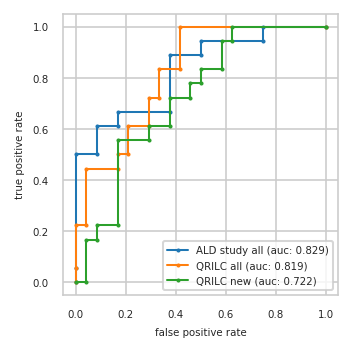

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.000 0.056     0.000 0.056     0.042 0.000
2          0.000 0.500     0.000 0.222     0.042 0.167
3          0.083 0.500     0.042 0.222     0.083 0.167
4          0.083 0.611     0.042 0.444     0.083 0.222
5          0.167 0.611     0.167 0.444     0.167 0.222
6          0.167 0.667     0.167 0.500     0.167 0.556
7          0.375 0.667     0.208 0.500     0.292 0.556
8          0.375 0.889     0.208 0.611     0.292 0.611
9          0.500 0.889     0.292 0.611     0.375 0.611
10         0.500 0.944     0.292 0.722     0.375 0.722
11         0.750 0.944     0.333 0.722     0.458 0.722
12         0.750 1.000     0.333 0.833     0.458 0.778
13         1.000 1.000     0.417 0.833     0.500 0.778
14           NaN   NaN     0.417 1.000     0.500 0.833
15           NaN   NaN     1.000 1.000     0.583 0.833
16           NaN   NaN       NaN   NaN     0.583 0.944
17           NaN   NaN       NaN   NaN     0.625 0.944
18           NaN   NaN       NaN   NaN     0.625 1.000
19           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,P31321
1,A0A0A0MRJ7;P12259,P60709;P63261,None
2,P14174,P04430,None
3,A0A0C4DGY8;D6RA00;Q9UHY7,P10636-2;P10636-6,None
4,P61981,P61981,None
5,P04075,A0A0A0MRJ7;P12259,None
6,C9JF17;P05090,P14174,None
7,Q6EMK4,P04075,None
8,Q9Y2T3;Q9Y2T3-3,P05413;S4R371,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


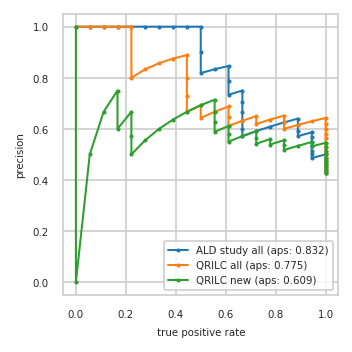

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.548 0.944
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.586 0.944     0.621 1.000     0.517 0.833
14         0.571 0.889     0.643 1.000     0.536 0.833
15         0.593 0.889     0.630 0.944     0.556 0.833
16         0.615 0.889     0.615 0.889     0.538 0.778
17         0.640 0.889     0.600 0.833     0.560 0.778
18         0.625 0.833     0.625 0.833     0.542 0.722
19         0.609 0.778     0.652 0.833     0.565 0.722
20         0.591 0.722     0.636 0.778     0.591 0.722
21         0.571 0.667     0.619 0.722     0.571 0.667
22         0.600 0.667     0.650 0.722     0.550 0.611
23         0.632 0.667     0.632 0.667     0.579 0.611
24         0.667 0.667     0.611 0.611     0.611 0.611
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.750 0.667     0.688 0.611     0.625 0.556
27         0.733 0.611     0.667 0.556     0.667 0.556
28         0.786 0.611     0.643 0.500     0.714 0.556
29         0.846 0.611     0.692 0.500     0.692 0.500
30         0.833 0.556     0.667 0.444     0.667 0.444
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         1.000 0.500     0.889 0.444     0.556 0.278
34         1.000 0.444     0.875 0.389     0.500 0.222
35         1.000 0.389     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


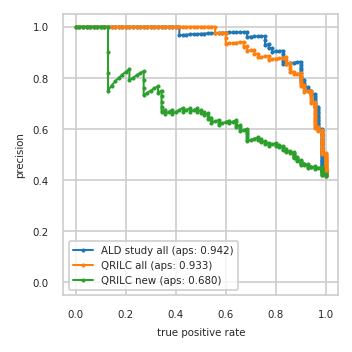

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


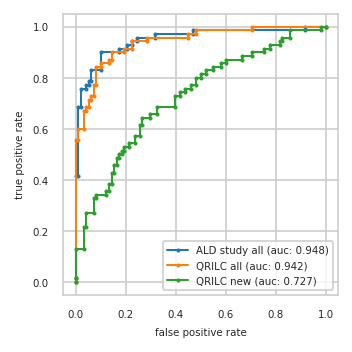

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}